<a href="https://colab.research.google.com/github/cerasole/ml4hep/blob/main/GNNs/torch_OrganicMoleculesFormationEnergy_QM9dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Networks

The preliminary code on graphs is instead in https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html

The code about the preprocessing, model and training/testing is at
https://github.com/pyg-team/pytorch_geometric/blob/master/examples/qm9_nn_conv.py

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.4.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 50.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 amd64 2.24.33-2ubuntu2.1 [15.9 kB]
Get:4 http://archive.ubun

In [3]:
import pathlib

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential
import networkx as nx

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, Set2Set, GCNConv
from torch_geometric.utils import remove_self_loops, to_networkx

import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm.auto import trange

In [9]:
dataset_path = pathlib.Path('data', 'QM9')
dataset_path

PosixPath('data/QM9')

In [53]:
raw_dataset = QM9(dataset_path)

In [54]:
raw_dataset, raw_dataset[0]

(QM9(130831),
 Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5]))

In [14]:
type(raw_dataset)

torch_geometric.datasets.qm9.QM9

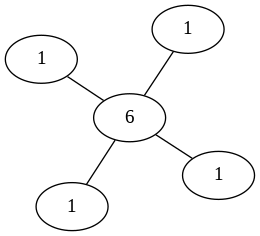

In [17]:
def draw_graph(graph: torch_geometric.data.data.Data) -> Image:
    """
    Plots a molecule from QM9 dataset. Node labels are atomic numbers.
    Edge lengths and node positions are arbitrary.
    """
    graph_nx = to_networkx(graph,
                           to_undirected=True)
    graph_graphviz = nx.nx_agraph.to_agraph(graph_nx)
    for node, type_ in zip(graph_graphviz.iternodes(), graph.z.detach().numpy()):
        node.attr['label'] = str(type_)
    return Image(graph_graphviz.draw(format='png', prog="neato"))

draw_graph(raw_dataset[0])  ### The number in the graph is the atomic number!!!

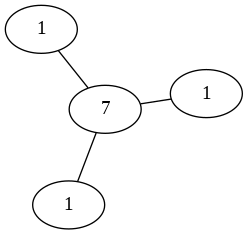

In [18]:
draw_graph(raw_dataset[1]) ### The number in the graph is the atomic number!!!

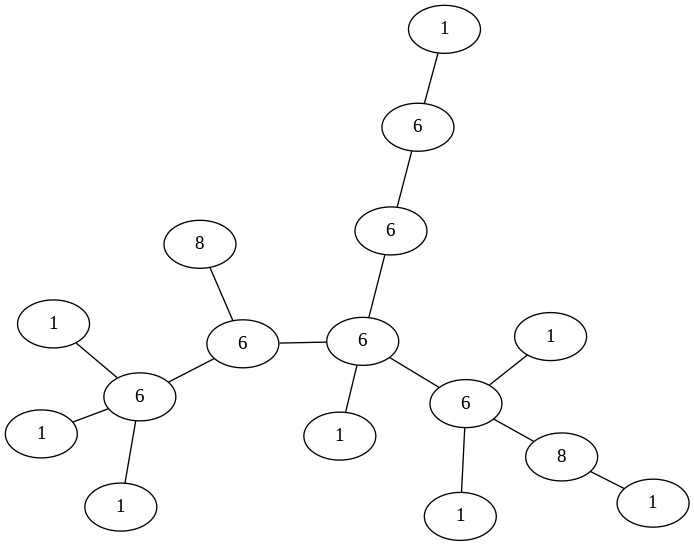

In [19]:
draw_graph(raw_dataset[10000])

In [20]:
raw_dataset.y  # the features!

tensor([[  0.0000,  13.2100, -10.5499,  ..., 157.7118, 157.7100, 157.7070],
        [  1.6256,   9.4600,  -6.9933,  ..., 293.6097, 293.5411, 191.3940],
        [  1.8511,   6.3100,  -7.9675,  ..., 799.5881, 437.9039, 282.9455],
        ...,
        [  1.2480,  73.6000,  -6.0763,  ...,   3.6712,   2.1431,   1.8950],
        [  1.9576,  77.4000,  -5.7743,  ...,   3.5285,   2.1513,   1.8658],
        [  0.8626,  69.4800,  -6.3022,  ...,   3.6402,   2.2176,   1.9379]])

In [21]:
raw_dataset.y[:,7]  # formation energy

tensor([ -1101.4878,  -1538.1477,  -2079.0779,  ..., -10360.8418,
         -9924.5469, -10901.7803])

In [82]:
TARGET_Y = 7

class SelectTarget(object):
    def __init__(self, target_column: int):
        self.target_column = target_column

    def __call__(self, data: torch.Tensor) -> torch.Tensor:
        data.y = data.y[:, self.target_column]
        return data


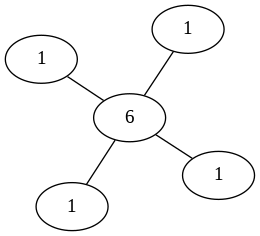

In [23]:
draw_graph(raw_dataset[0])  ### The number in the graph is the atomic number!!!

In [24]:
raw_dataset[0].x
# data.x: Node feature matrix with shape [num_nodes, num_node_features]
# - [0:5] contain one-hot encoded atom types
# - 5 is the atomic number
# - 6 is boolean indicator whether the atom is aromatic
# - [7:10] conain one-hot encoded hybridization type

tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [26]:
raw_dataset[0].y

tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
             1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
           -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
           157.7070]])

In [27]:
raw_dataset[0].pos

tensor([[-1.2700e-02,  1.0858e+00,  8.0000e-03],
        [ 2.2000e-03, -6.0000e-03,  2.0000e-03],
        [ 1.0117e+00,  1.4638e+00,  3.0000e-04],
        [-5.4080e-01,  1.4475e+00, -8.7660e-01],
        [-5.2380e-01,  1.4379e+00,  9.0640e-01]])

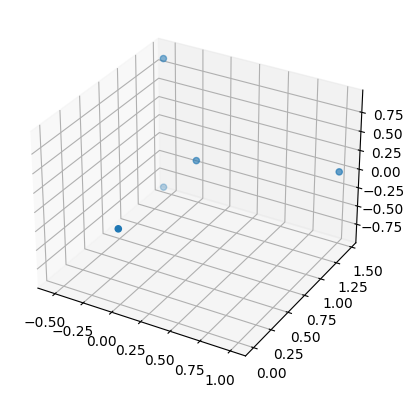

In [28]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(*raw_dataset[0].pos.T);

In [29]:
raw_dataset[0].z  # --> Atomic number of the atoms : this is CH4

tensor([6, 1, 1, 1, 1])

## Preprocessing

In [83]:
import torch_geometric.transforms as T
transform = T.Compose([SelectTarget(TARGET_Y), T.Distance(norm=False)])

# transformation of the input data.
# - SelectTarget selects the target column and torch_geometric.transforms.
# - Distance appends Euclidean distance between pos vectors to the edge attributes.

In [46]:
st = SelectTarget(TARGET_Y)

In [55]:
raw_dataset.y

tensor([[  0.0000,  13.2100, -10.5499,  ..., 157.7118, 157.7100, 157.7070],
        [  1.6256,   9.4600,  -6.9933,  ..., 293.6097, 293.5411, 191.3940],
        [  1.8511,   6.3100,  -7.9675,  ..., 799.5881, 437.9039, 282.9455],
        ...,
        [  1.2480,  73.6000,  -6.0763,  ...,   3.6712,   2.1431,   1.8950],
        [  1.9576,  77.4000,  -5.7743,  ...,   3.5285,   2.1513,   1.8658],
        [  0.8626,  69.4800,  -6.3022,  ...,   3.6402,   2.2176,   1.9379]])

In [57]:
st(raw_dataset)

tensor([ -1101.4878,  -1538.1477,  -2079.0779,  ..., -10360.8418,
         -9924.5469, -10901.7803])

In [59]:
T.Distance(norm=False)(raw_dataset)

QM9(130831)

tensor([[  0.0000,  13.2100, -10.5499,  ..., 157.7118, 157.7100, 157.7070],
        [  1.6256,   9.4600,  -6.9933,  ..., 293.6097, 293.5411, 191.3940],
        [  1.8511,   6.3100,  -7.9675,  ..., 799.5881, 437.9039, 282.9455],
        ...,
        [  1.2480,  73.6000,  -6.0763,  ...,   3.6712,   2.1431,   1.8950],
        [  1.9576,  77.4000,  -5.7743,  ...,   3.5285,   2.1513,   1.8658],
        [  0.8626,  69.4800,  -6.3022,  ...,   3.6402,   2.2176,   1.9379]])

Before, we have uploaded the raw dataset, now we upload a processed one

In [110]:
torch.manual_seed(42)
dataset = QM9(dataset_path, transform=transform).shuffle()

In [111]:
mean = dataset.data.y.mean(dim = 0, keepdim = True)
std = dataset.data.y.std(dim = 0, keepdim = True)
dataset.data.y = (dataset.data.y - mean) / std
mean, std = mean[:, TARGET_Y].item(), std[:, TARGET_Y].item()

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [68]:
len(dataset)

130831

In [112]:
test_dataset = dataset[:10000]
val_dataset = dataset[10000:20000]
train_dataset = dataset[20000:40000]

In [113]:
# Create pytorch objects for handling the data
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

A base GNN for molecules.

In [114]:
class SlimeNet (torch.nn.Module):
    def __init__ (self, hidden_dim: int):
        super().__init__()
        self.lin0 = torch.nn.Linear(dataset.num_features, hidden_dim)
        self.conv = GCNConv(hidden_dim, hidden_dim)
        self.set2set = Set2Set(hidden_dim, processing_steps = 1)
        self.lin1 = torch.nn.Linear(2*hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, 1)
        return

    def forward (self, data):
        # Nothing special, just a sequece of transformations
        # But pay attention to the API signatures of the graph layers
        # Apply a linear layer+ReLu to the featues of each node independenly
        out = F.relu(self.lin0(data.x))
        # Apply a graph convolution
        out = F.relu(self.conv(out, data.edge_index))
        # Apply a Set2Set pooling operation from
        # "Order Matters: Sequence to sequence for sets"
        # https://arxiv.org/abs/1511.06391 paper
        out = self.set2set(out, data.batch)
        # And a classic fully-connected head
        out = F.relu(self.lin1(out))
        out = self.lin2(out)
        return out.view(-1)

In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [117]:
def evaluate_model (model, epochs = 15):
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode = "min",
                                                         factor = 0.7,
                                                         patience = 5,
                                                         min_lr = 1e-5)

  def train (epoch):
    model.train()
    loss_all = 0
    for data in train_loader:
      data = data.to(device)
      optimizer.zero_grad()
      loss = F.mse_loss(model(data), data.y)
      loss.backward()
      loss_all += loss.item() * data.num_graphs
      optimizer.step()
    return loss_all / len(train_loader.dataset)

  def test (loader):
    model.eval()
    error = 0
    for data in loader:
      data = data.to(device)
      error += (model(data)*std - data.y*std).abs().sum().item() # MAE = Mean Absolute Value
    return error / len(loader.dataset)

  best_val_error = None
  for epoch in trange(epochs):
        lr = scheduler.optimizer.param_groups[0]['lr']
        loss = train(epoch)
        val_error = test(val_loader)
        scheduler.step(val_error)

        if best_val_error is None or val_error <= best_val_error:
            test_error = test(test_loader)
            best_val_error = val_error

        print(f'Epoch: {epoch:03d}, LR: {lr:7f}, Loss: {loss:.7f}, '
              f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')


In [118]:
evaluate_model(SlimeNet(16))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 000, LR: 0.001000, Loss: 0.9110288, Val MAE: 630.4476451, Test MAE: 641.6348348
Epoch: 001, LR: 0.001000, Loss: 0.5404422, Val MAE: 520.2654851, Test MAE: 529.8124465
Epoch: 002, LR: 0.001000, Loss: 0.4559221, Val MAE: 509.2865655, Test MAE: 519.2470790
Epoch: 003, LR: 0.001000, Loss: 0.4220531, Val MAE: 476.3400029, Test MAE: 486.3437336
Epoch: 004, LR: 0.001000, Loss: 0.4028106, Val MAE: 451.3020460, Test MAE: 462.0412992
Epoch: 005, LR: 0.001000, Loss: 0.3931480, Val MAE: 450.9344129, Test MAE: 461.1072859
Epoch: 006, LR: 0.001000, Loss: 0.3868305, Val MAE: 372.1884602, Test MAE: 383.3468015
Epoch: 007, LR: 0.001000, Loss: 0.3825691, Val MAE: 549.3518054, Test MAE: 383.3468015
Epoch: 008, LR: 0.001000, Loss: 0.3802492, Val MAE: 387.1366868, Test MAE: 383.3468015
Epoch: 009, LR: 0.001000, Loss: 0.3777285, Val MAE: 425.1426750, Test MAE: 383.3468015
Epoch: 010, LR: 0.001000, Loss: 0.3772233, Val MAE: 518.7171215, Test MAE: 383.3468015
Epoch: 011, LR: 0.001000, Loss: 0.3775664, 

In [120]:
evaluate_model(SlimeNet(32))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 000, LR: 0.001000, Loss: 0.8442500, Val MAE: 583.3686895, Test MAE: 592.8441222
Epoch: 001, LR: 0.001000, Loss: 0.5097483, Val MAE: 476.0487523, Test MAE: 485.6018891
Epoch: 002, LR: 0.001000, Loss: 0.4189401, Val MAE: 420.6810439, Test MAE: 431.2648958
Epoch: 003, LR: 0.001000, Loss: 0.3925229, Val MAE: 465.0525190, Test MAE: 431.2648958
Epoch: 004, LR: 0.001000, Loss: 0.3854741, Val MAE: 470.1225577, Test MAE: 431.2648958
Epoch: 005, LR: 0.001000, Loss: 0.3815470, Val MAE: 396.5417066, Test MAE: 407.5131520
Epoch: 006, LR: 0.001000, Loss: 0.3780129, Val MAE: 413.3301561, Test MAE: 407.5131520
Epoch: 007, LR: 0.001000, Loss: 0.3782604, Val MAE: 393.6557235, Test MAE: 404.5313252
Epoch: 008, LR: 0.001000, Loss: 0.3748502, Val MAE: 391.0245760, Test MAE: 401.6025842
Epoch: 009, LR: 0.001000, Loss: 0.3748664, Val MAE: 422.3077537, Test MAE: 401.6025842
Epoch: 010, LR: 0.001000, Loss: 0.3711531, Val MAE: 381.6058570, Test MAE: 391.7364624
Epoch: 011, LR: 0.001000, Loss: 0.3726909, 